## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Dataset Loading

In [ ]:
pollution_data = pd.read_csv("Data/pollution_data.csv")
pollution_data['Date'] = pd.to_datetime(pollution_data['Date'])
pollution_data['Quarter'] = pollution_data['Date'].dt.quarter
pollution_data['Year'] = pollution_data['Date'].dt.year
avg_data = pollution_data.groupby(['State','County', 'Year', 'Quarter']).mean().reset_index()

census_data = pd.read_csv('Data/county_data.csv')

In [ ]:
merged_data = pd.merge(avg_data, census_data, on=['State', 'County'], how='outer')
merged_data.head()

,State,County,Year,Quarter,O3 Mean,O3 AQI,CO Mean,CO AQI,SO2 Mean,SO2 AQI,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
1,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
2,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
3,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
4,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7


In [ ]:
count_no_null_rows = merged_data.notna().all(axis=1).sum()
print('The number of rows where data is not null:', count_no_null_rows)

The number of rows where data is not null: 62043


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63346 entries, 0 to 63345
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             63345 non-null  object 
 1   County            63345 non-null  object 
 2   Year              62876 non-null  float64
 3   Quarter           62876 non-null  float64
 4   O3 Mean           62876 non-null  float64
 5   O3 AQI            62876 non-null  float64
 6   CO Mean           62876 non-null  float64
 7   CO AQI            62876 non-null  float64
 8   SO2 Mean          62876 non-null  float64
 9   SO2 AQI           62876 non-null  float64
 10  NO2 Mean          62876 non-null  float64
 11  NO2 AQI           62876 non-null  float64
 12  TractId           63312 non-null  float64
 13  TotalPop          63312 non-null  float64
 14  Men               63312 non-null  float64
 15  Women             63312 non-null  float64
 16  Hispanic          62993 non-null  float6

In [ ]:
merged_data = merged_data.dropna()
merged_data.head()

,State,County,Year,Quarter,O3 Mean,O3 AQI,CO Mean,CO AQI,SO2 Mean,SO2 AQI,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
1,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
2,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
3,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7
4,Alabama,Jefferson County,2017.0,1.0,0.028114,34.068966,0.395504,6.862069,0.747677,3.534483,...,2.1,4.9,2.4,23.1,1220.0,89.7,3.9,2.5,3.9,10.7


In [ ]:
def determine_transportation_category(row):
    max_mode = max(row['Drive'], row['Carpool'], row['Transit'], row['Walk'], row['OtherTransp'])
    if max_mode == row['Drive']:
        return 'Driving'
    elif max_mode == row['Carpool']:
        return 'Carpooling'
    elif max_mode == row['Transit']:
        return 'Public Transit'
    elif max_mode == row['Walk']:
        return 'Walking'
    else:
        return 'Other'

merged_data['TransportationMode'] = merged_data.apply(determine_transportation_category, axis=1)
merged_data['TransportationMode'].unique()

array(['Driving', 'Public Transit', 'Carpooling', 'Walking', 'Other'],
      dtype=object)

In [ ]:
features = ['Men', 'Women', 'Income', 'Poverty', 'MeanCommute', 'O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']

target = 'TransportationMode'

X = merged_data[features]
y = merged_data[target]

X

,Men,Women,Income,Poverty,MeanCommute,O3 Mean,CO Mean,SO2 Mean,NO2 Mean
0,1605.0,1509.0,28517.0,41.3,23.1,0.028114,0.395504,0.747677,9.722237
1,1605.0,1509.0,28517.0,41.3,23.1,0.028114,0.395504,0.747677,9.722237
2,1605.0,1509.0,28517.0,41.3,23.1,0.028114,0.395504,0.747677,9.722237
3,1605.0,1509.0,28517.0,41.3,23.1,0.028114,0.395504,0.747677,9.722237
4,1605.0,1509.0,28517.0,41.3,23.1,0.028114,0.395504,0.747677,9.722237
...,...,...,...,...,...,...,...,...,...
62871,2927.0,2427.0,68031.0,4.6,15.5,0.032203,0.119187,0.190347,4.399790
62872,1917.0,2605.0,40938.0,19.0,21.1,0.032203,0.119187,0.190347,4.399790
62873,2568.0,2433.0,94392.0,5.9,19.0,0.032203,0.119187,0.190347,4.399790
62874,2215.0,2062.0,84946.0,5.1,26.9,0.032203,0.119187,0.190347,4.399790


### Visualization

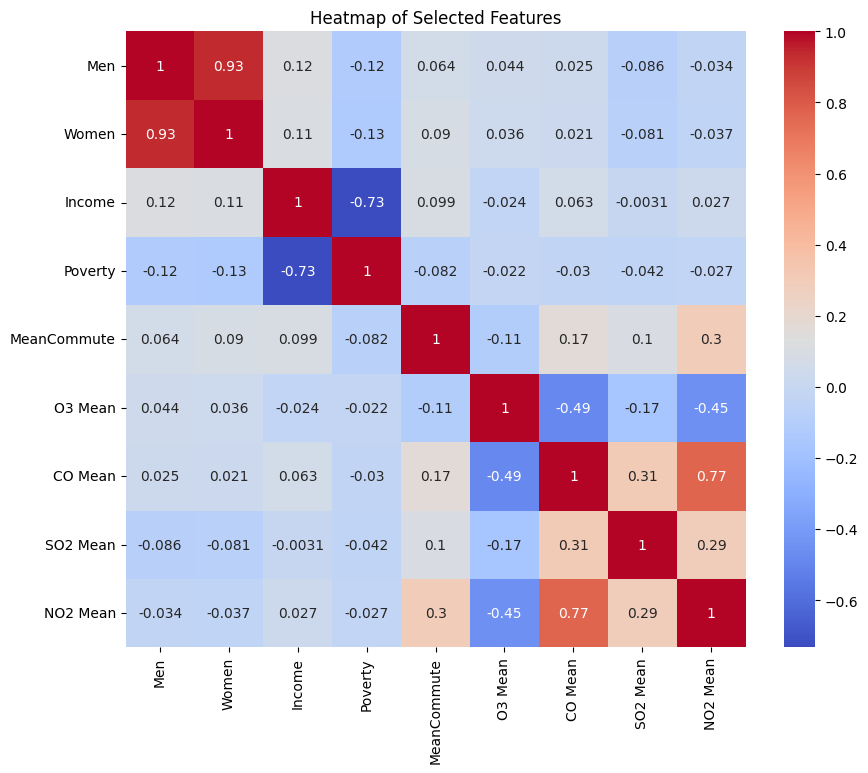

In [ ]:
# Heatmap
data = merged_data[features]

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Selected Features')
plt.show()


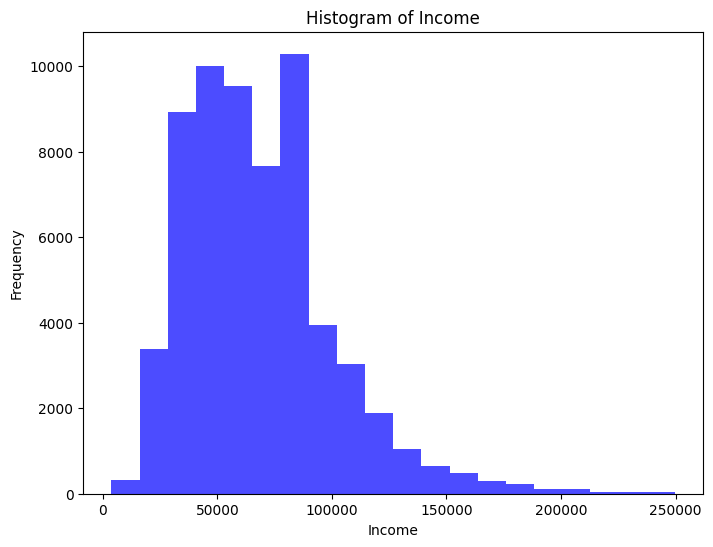

In [ ]:
# Histogram of Income
variable = 'Income'

plt.figure(figsize=(8, 6))
plt.hist(merged_data[variable], bins=20, color='blue', alpha=0.7)
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Histogram of {variable}')
plt.show()


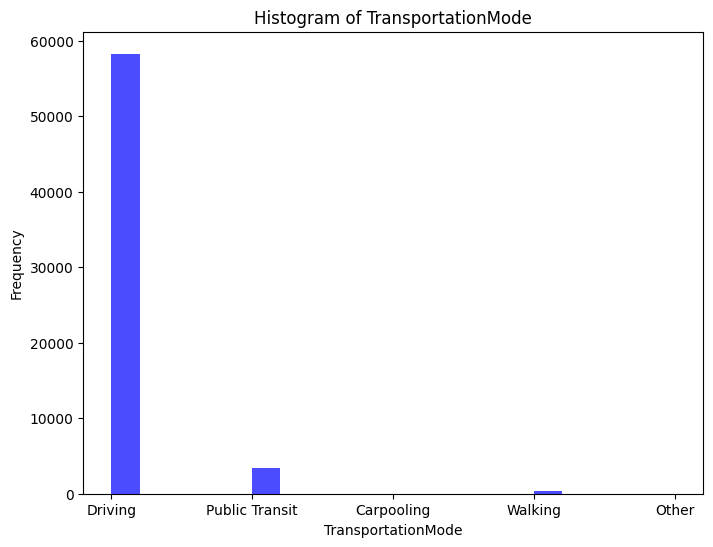

In [ ]:
# Histogram of Transportation Mode

variable = 'TransportationMode'

plt.figure(figsize=(8, 6))
plt.hist(merged_data[variable], bins=20, color='blue', alpha=0.7)
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Histogram of {variable}')
plt.show()


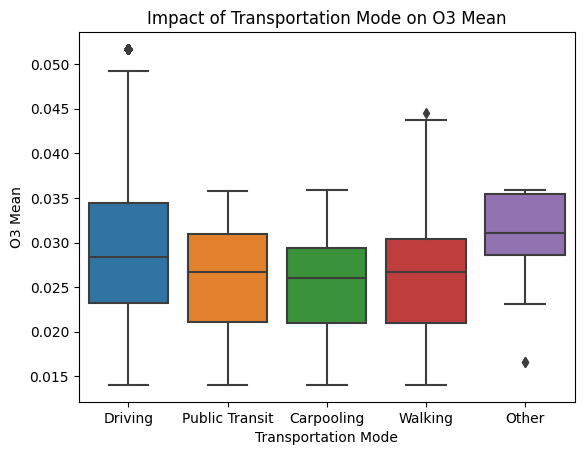

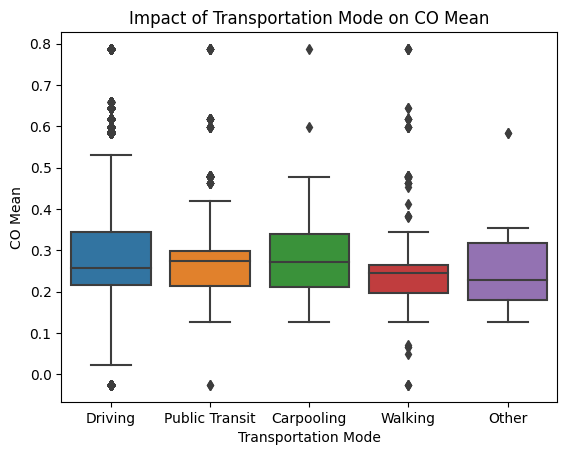

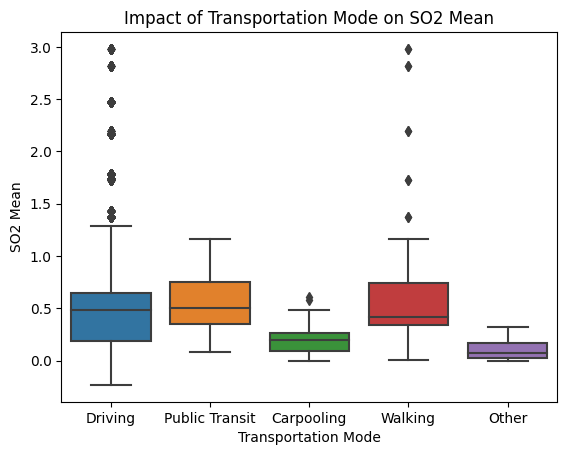

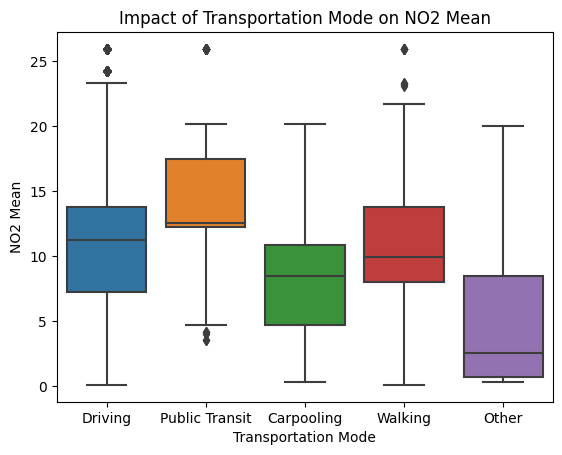

In [ ]:
variables = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean', 'TransportationMode']

for variable in variables[:-1]:
    sns.boxplot(x='TransportationMode', y=variable, data=merged_data)
    plt.title(f'Impact of Transportation Mode on {variable}')
    plt.ylabel(variable)
    plt.xlabel('Transportation Mode')
    plt.show()


In [ ]:
# Perform ANOVA test
for variable in variables[:-1]:
    groups = [group[1] for group in merged_data.groupby('TransportationMode')[variable]]
    f_statistic, p_value = stats.f_oneway(*groups)
    print(f'ANOVA for {variable}: F-statistic = {f_statistic}')

ANOVA for O3 Mean: F-statistic = 102.13426456091503
ANOVA for CO Mean: F-statistic = 31.875525451353948
ANOVA for SO2 Mean: F-statistic = 10.596269631270792
ANOVA for NO2 Mean: F-statistic = 263.2171449744319


The F-statistic measures the ratio of the variance between groups (transportation modes) to the variance within groups. A high F-statistic indicates that there are significant differences in 'Variables' among different transportation modes. In other words,

1. Transportation modes have a strong impact on 'O3 Mean'
2. Transportation modes have a significant impact 'CO Mean'.
3. Transportation modes have a least impact on 'SO2 Mean'.
4. Transportation modes have a strong impact 'NO2 Mean'.

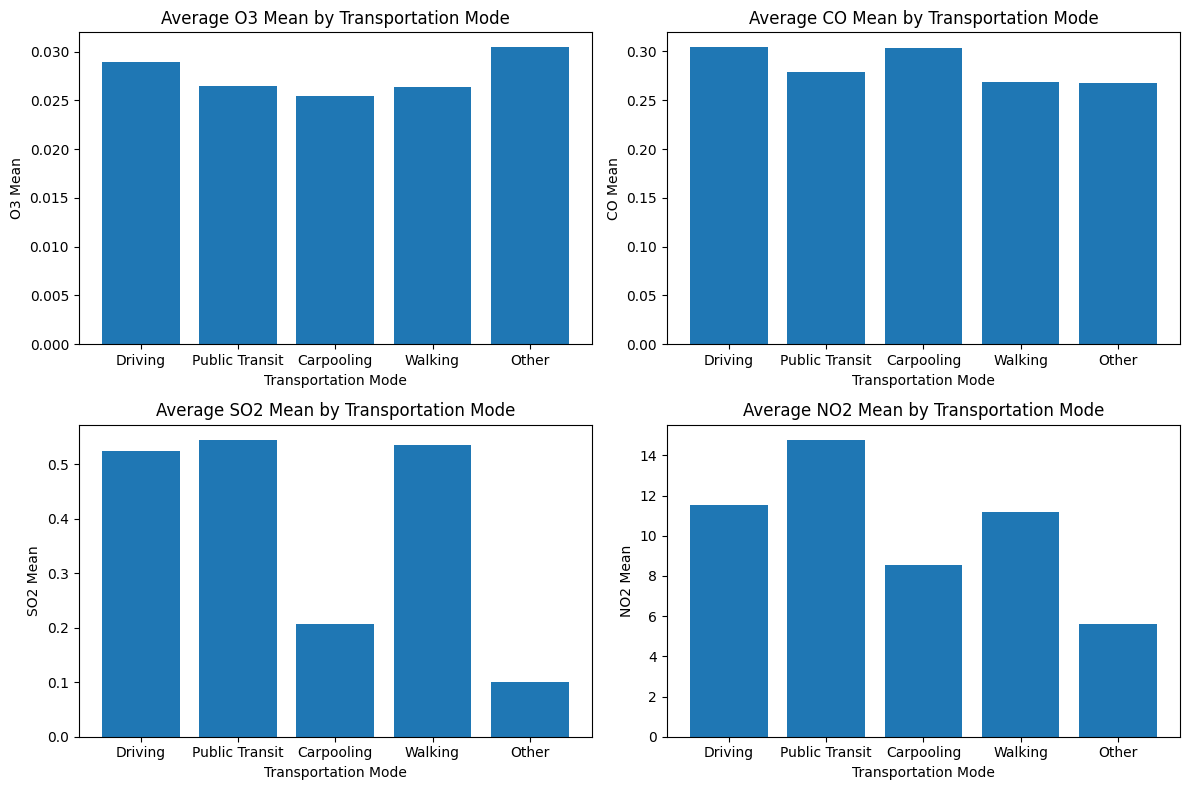

In [ ]:
pollution_variables = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']
transportation_modes = merged_data['TransportationMode'].unique()

average_pollution_by_mode = []
for mode in transportation_modes:
    mode_data = merged_data[merged_data['TransportationMode'] == mode][pollution_variables].mean()
    average_pollution_by_mode.append(mode_data)

plt.figure(figsize=(12, 8))
for i, variable in enumerate(pollution_variables):
    plt.subplot(2, 2, i+1)
    plt.bar(transportation_modes, [data[variable] for data in average_pollution_by_mode])
    plt.title(f'Average {variable} by Transportation Mode')
    plt.xlabel('Transportation Mode')
    plt.ylabel(variable)

plt.tight_layout()
plt.show()


## Question # 1

In [ ]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9875090660004835
                precision    recall  f1-score   support

    Carpooling       0.00      0.00      0.00         1
       Driving       0.99      1.00      0.99     11672
         Other       1.00      0.50      0.67         4
Public Transit       0.94      0.87      0.90       673
       Walking       0.97      0.49      0.65        59

      accuracy                           0.99     12409
     macro avg       0.78      0.57      0.64     12409
  weighted avg       0.99      0.99      0.99     12409



## Question # 2

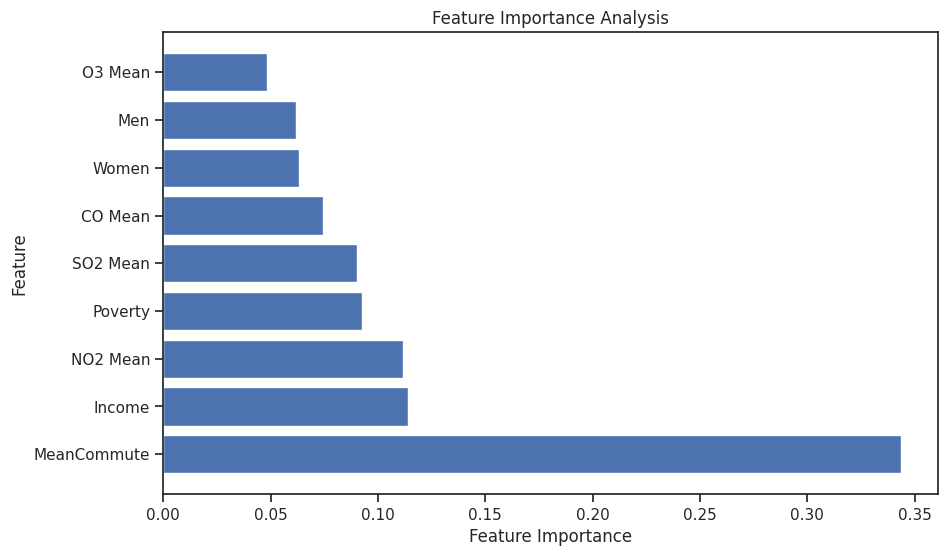

Feature Importance Rankings:
       Feature  Importance
4  MeanCommute    0.343789
2       Income    0.114135
8     NO2 Mean    0.111660
3      Poverty    0.092455
7     SO2 Mean    0.090273
6      CO Mean    0.074378
1        Women    0.063226
0          Men    0.061611
5      O3 Mean    0.048473


In [ ]:
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()

print("Feature Importance Rankings:")
print(feature_importance_df)


## Question # 3

In [ ]:
# Use Recursive Feature Elimination (RFE)
rfe = RFE(clf, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
# Train
clf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = clf.predict(X_test[selected_features])

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Reduced Features: {accuracy}")
report = classification_report(y_test, y_pred)
print(report)


Accuracy with Reduced Features: 0.9855749858973326
                precision    recall  f1-score   support

    Carpooling       0.00      0.00      0.00         1
       Driving       0.99      1.00      0.99     11672
         Other       1.00      0.75      0.86         4
Public Transit       0.92      0.85      0.89       673
       Walking       0.90      0.46      0.61        59

      accuracy                           0.99     12409
     macro avg       0.76      0.61      0.67     12409
  weighted avg       0.99      0.99      0.98     12409



## Question # 4

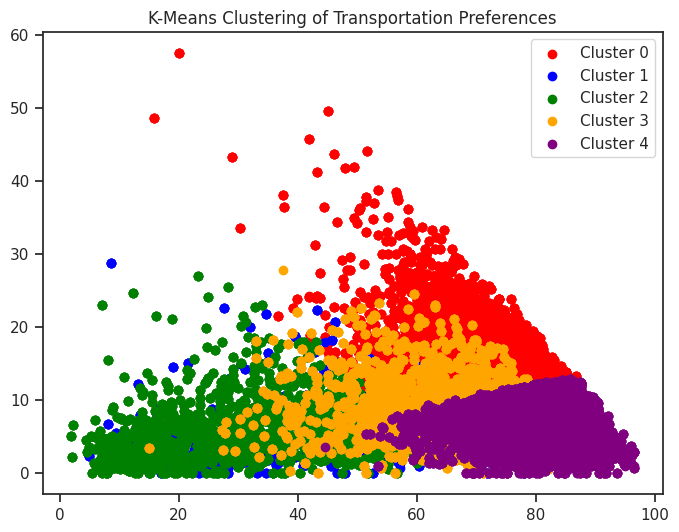

Cluster 0 - Numbers: 17531
Cluster 1 - Numbers: 1132
Cluster 2 - Numbers: 4640
Cluster 3 - Numbers: 5830
Cluster 4 - Numbers: 32910


In [ ]:
# Select the relevant features
cluster_features = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[cluster_features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clustering results
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(8, 6))
for cluster_id in range(5):
    cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data[cluster_features[0]], cluster_data[cluster_features[1]], c=colors[cluster_id], label=f'Cluster {cluster_id}')

plt.title('K-Means Clustering of Transportation Preferences')
plt.legend()
plt.show()

# Analyze the clustering results
for cluster_id in range(5):
    cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} - Numbers: {len(cluster_data)}")

## Question # 5

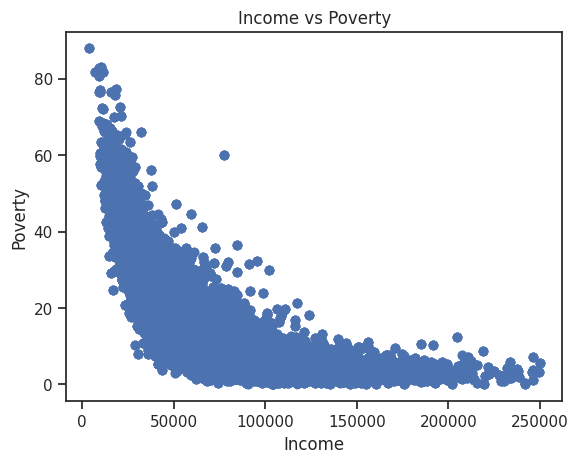

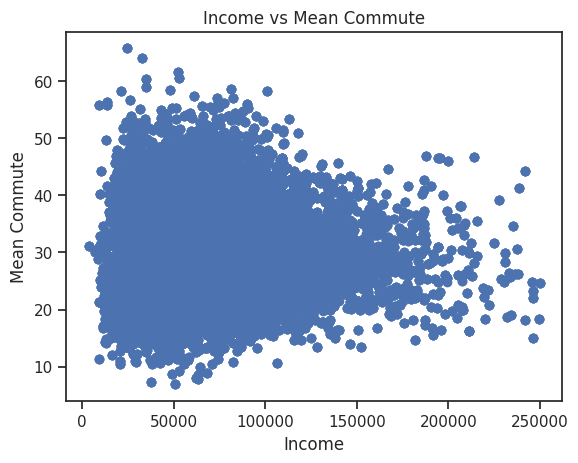

In [ ]:
# Create a scatter plot of income and poverty
plt.scatter(merged_data['Income'], merged_data['Poverty'])
plt.xlabel('Income')
plt.ylabel('Poverty')
plt.title('Income vs Poverty')
plt.show()

# Create a scatter plot of income and MeanCommute
plt.scatter(merged_data['Income'], merged_data['MeanCommute'])
plt.xlabel('Income')
plt.ylabel('Mean Commute')
plt.title('Income vs Mean Commute')
plt.show()



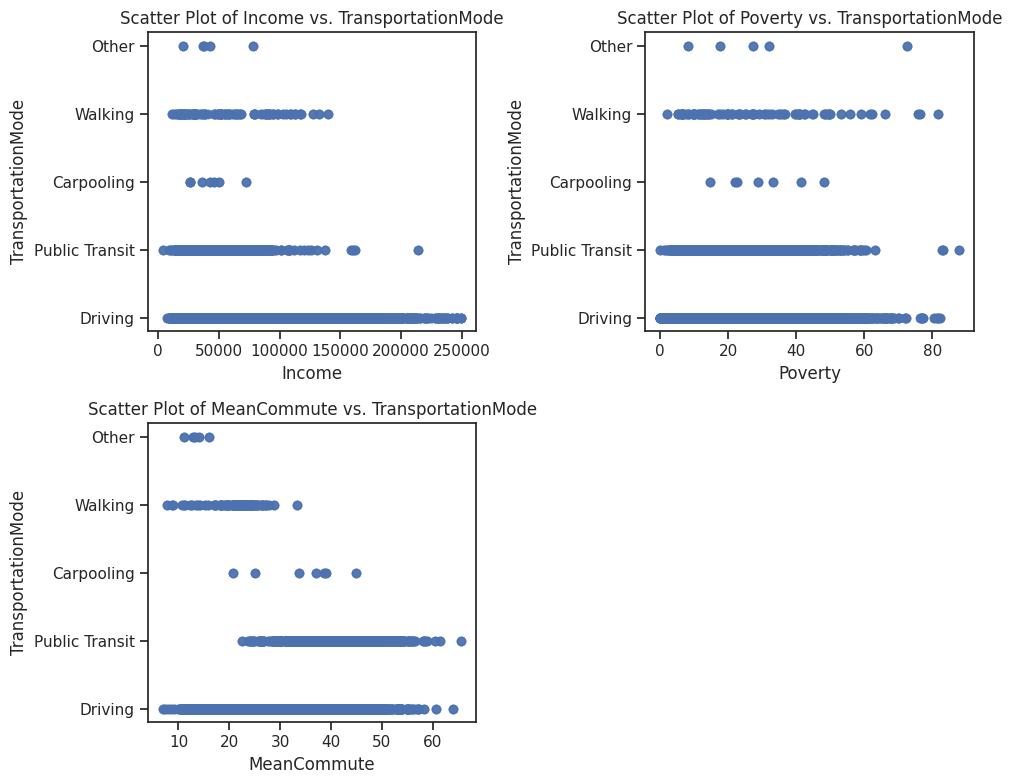

In [ ]:
# Select social and economic features
economic_features = ['Income', 'Poverty', 'MeanCommute']

# Visualization
plt.figure(figsize=(10, 8))

# Create scatter plots
for feature in economic_features:
    plt.subplot(2, 2, economic_features.index(feature) + 1)
    plt.scatter(merged_data[feature], merged_data['TransportationMode'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('TransportationMode')
    plt.title(f'Scatter Plot of {feature} vs. TransportationMode')

plt.tight_layout()
plt.show()


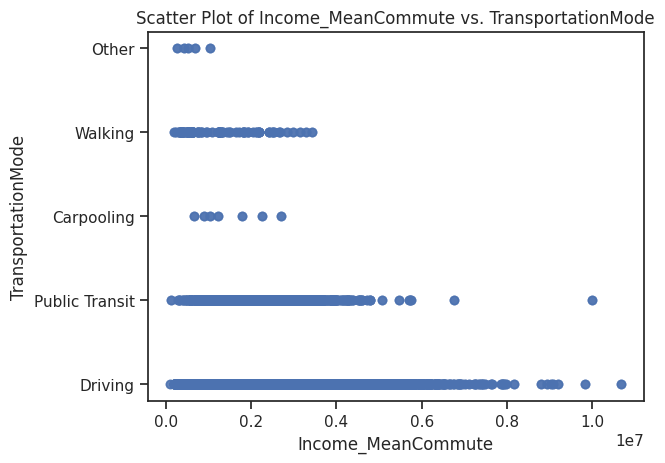

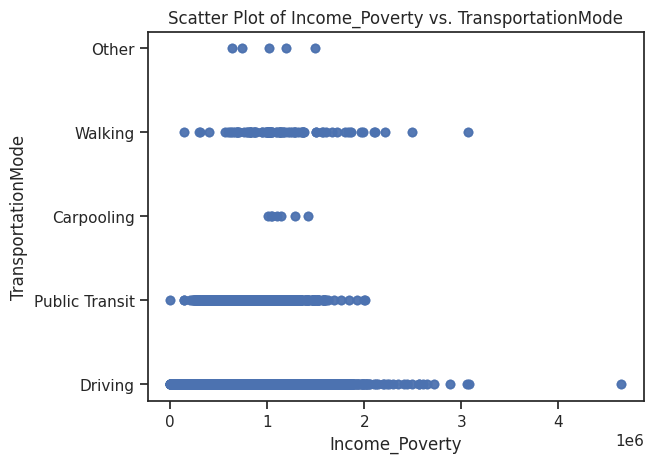

In [ ]:
# Create interaction terms
merged_data['Income_MeanCommute'] = merged_data['Income'] * merged_data['MeanCommute']
merged_data['Income_Poverty'] = merged_data['Income'] * merged_data['Poverty']

# Create scatter plots
plt.scatter(merged_data['Income_MeanCommute'], merged_data['TransportationMode'], alpha=0.5)
plt.xlabel('Income_MeanCommute')
plt.ylabel('TransportationMode')
plt.title('Scatter Plot of Income_MeanCommute vs. TransportationMode')
plt.show()

# Create scatter plots
plt.scatter(merged_data['Income_Poverty'], merged_data['TransportationMode'], alpha=0.5)
plt.xlabel('Income_Poverty')
plt.ylabel('TransportationMode')
plt.title('Scatter Plot of Income_Poverty vs. TransportationMode')
plt.show()